### Full example
#### Build the preprocessing head

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import Dense, Normalization, Embedding

In [2]:
tf.__version__

'2.8.0'

In [3]:
SHUFFLE_BUFFER = 500
BATCH_SIZE = 2

In [4]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [7]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal         object
target        int64
dtype: object

In [8]:
target = df.pop('target')

In [9]:
binary_feature_names = []
categorical_feature_names = []
numeric_feature_names= []

for name, values in df.items():
    nunique = df[name].nunique()
    print(f"{name:10s}: {nunique}", end='\t')
    if nunique == 2:
        print(f"recommand to Binary")
        binary_feature_names.append(name)
    elif nunique <= 10:
        print(f"recommand to Categorical")
        categorical_feature_names.append(name)
    else:
        print(f"recommand to numerical")
        numeric_feature_names.append(name)

age       : 41	recommand to numerical
sex       : 2	recommand to Binary
cp        : 5	recommand to Categorical
trestbps  : 50	recommand to numerical
chol      : 152	recommand to numerical
fbs       : 2	recommand to Binary
restecg   : 3	recommand to Categorical
thalach   : 91	recommand to numerical
exang     : 2	recommand to Binary
oldpeak   : 40	recommand to numerical
slope     : 3	recommand to Categorical
ca        : 4	recommand to Categorical
thal      : 5	recommand to Categorical


In [10]:
binary_feature_names

['sex', 'fbs', 'exang']

In [11]:
categorical_feature_names

['cp', 'restecg', 'slope', 'ca', 'thal']

In [12]:
numeric_feature_names

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [13]:
numeric_features = df[numeric_feature_names]

In [14]:
numeric_features

,age,trestbps,chol,thalach,oldpeak
0,63,145,233,150,2.3
1,67,160,286,108,1.5
2,67,120,229,129,2.6
3,37,130,250,187,3.5
4,41,130,204,172,1.4
...,...,...,...,...,...
298,52,118,186,190,0.0
299,43,132,341,136,3.0
300,65,135,254,127,2.8
301,48,130,256,150,0.0


In [15]:
inputs = {}
for name, column in df.items():
    if type(column[0]) == str:
        dtype = tf.string
    elif (name in categorical_feature_names or 
          name in binary_feature_names):
        dtype = tf.int64
    else:
        dtype = tf.float32
        
    inputs[name] = Input(shape=(), name=name, dtype=dtype)

In [16]:
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

##### Binary inputs

In [17]:
preprocessed = []

for name in binary_feature_names:
    inp = inputs[name]
    inp = inp[:, tf.newaxis]
    float_value = tf.cast(inp, tf.float32)
    preprocessed.append(float_value)

preprocessed

Metal device set to: Apple M1


2022-08-06 22:10:54.682726: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-06 22:10:54.682813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>]

##### Numeric inputs

In [18]:
def stack_dict(inputs, fun=tf.stack):
    values = []
    for key in sorted(inputs.keys()):
        values.append(tf.cast(inputs[key], dtype=tf.float32))
    
    return fun(values, axis=-1)

In [19]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(stack_dict(dict(numeric_features)))

2022-08-06 22:10:54.737026: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-06 22:10:54.785999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-06 22:10:54.799768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [20]:
numeric_inputs = {}
for name in numeric_feature_names:
    numeric_inputs[name] = inputs[name]

numeric_inputs = stack_dict(numeric_inputs)
numeric_normalized = normalizer(numeric_inputs)

preprocessed.append(numeric_normalized)

preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization')>]

##### Categorical features

In [21]:
for name in categorical_feature_names:
    vocab = sorted(set(df[name]))
    print(f'name: {name}')
    print(f'vocab: {vocab}\n')
    
    if type(vocab[0]) is str:
        lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
    else:
        lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')
    
    x = inputs[name][:, tf.newaxis]
    x = lookup(x)
    preprocessed.append(x)

name: cp
vocab: [0, 1, 2, 3, 4]

name: restecg
vocab: [0, 1, 2]

name: slope
vocab: [1, 2, 3]

name: ca
vocab: [0, 1, 2, 3]

name: thal
vocab: ['1', '2', 'fixed', 'normal', 'reversible']



In [22]:
preprocessed

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'tf.cast_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'normalization')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'integer_lookup')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'integer_lookup_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'integer_lookup_3')>,
 <KerasTensor: shape=(None, 6) dtype=float32 (created by layer 'string_lookup')>]

In [23]:
preprocessed_result = tf.concat(preprocessed, axis=-1)

In [24]:
preprocessed_result

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'tf.concat')>

In [25]:
preprocessor = tf.keras.Model(inputs, preprocessed_result)

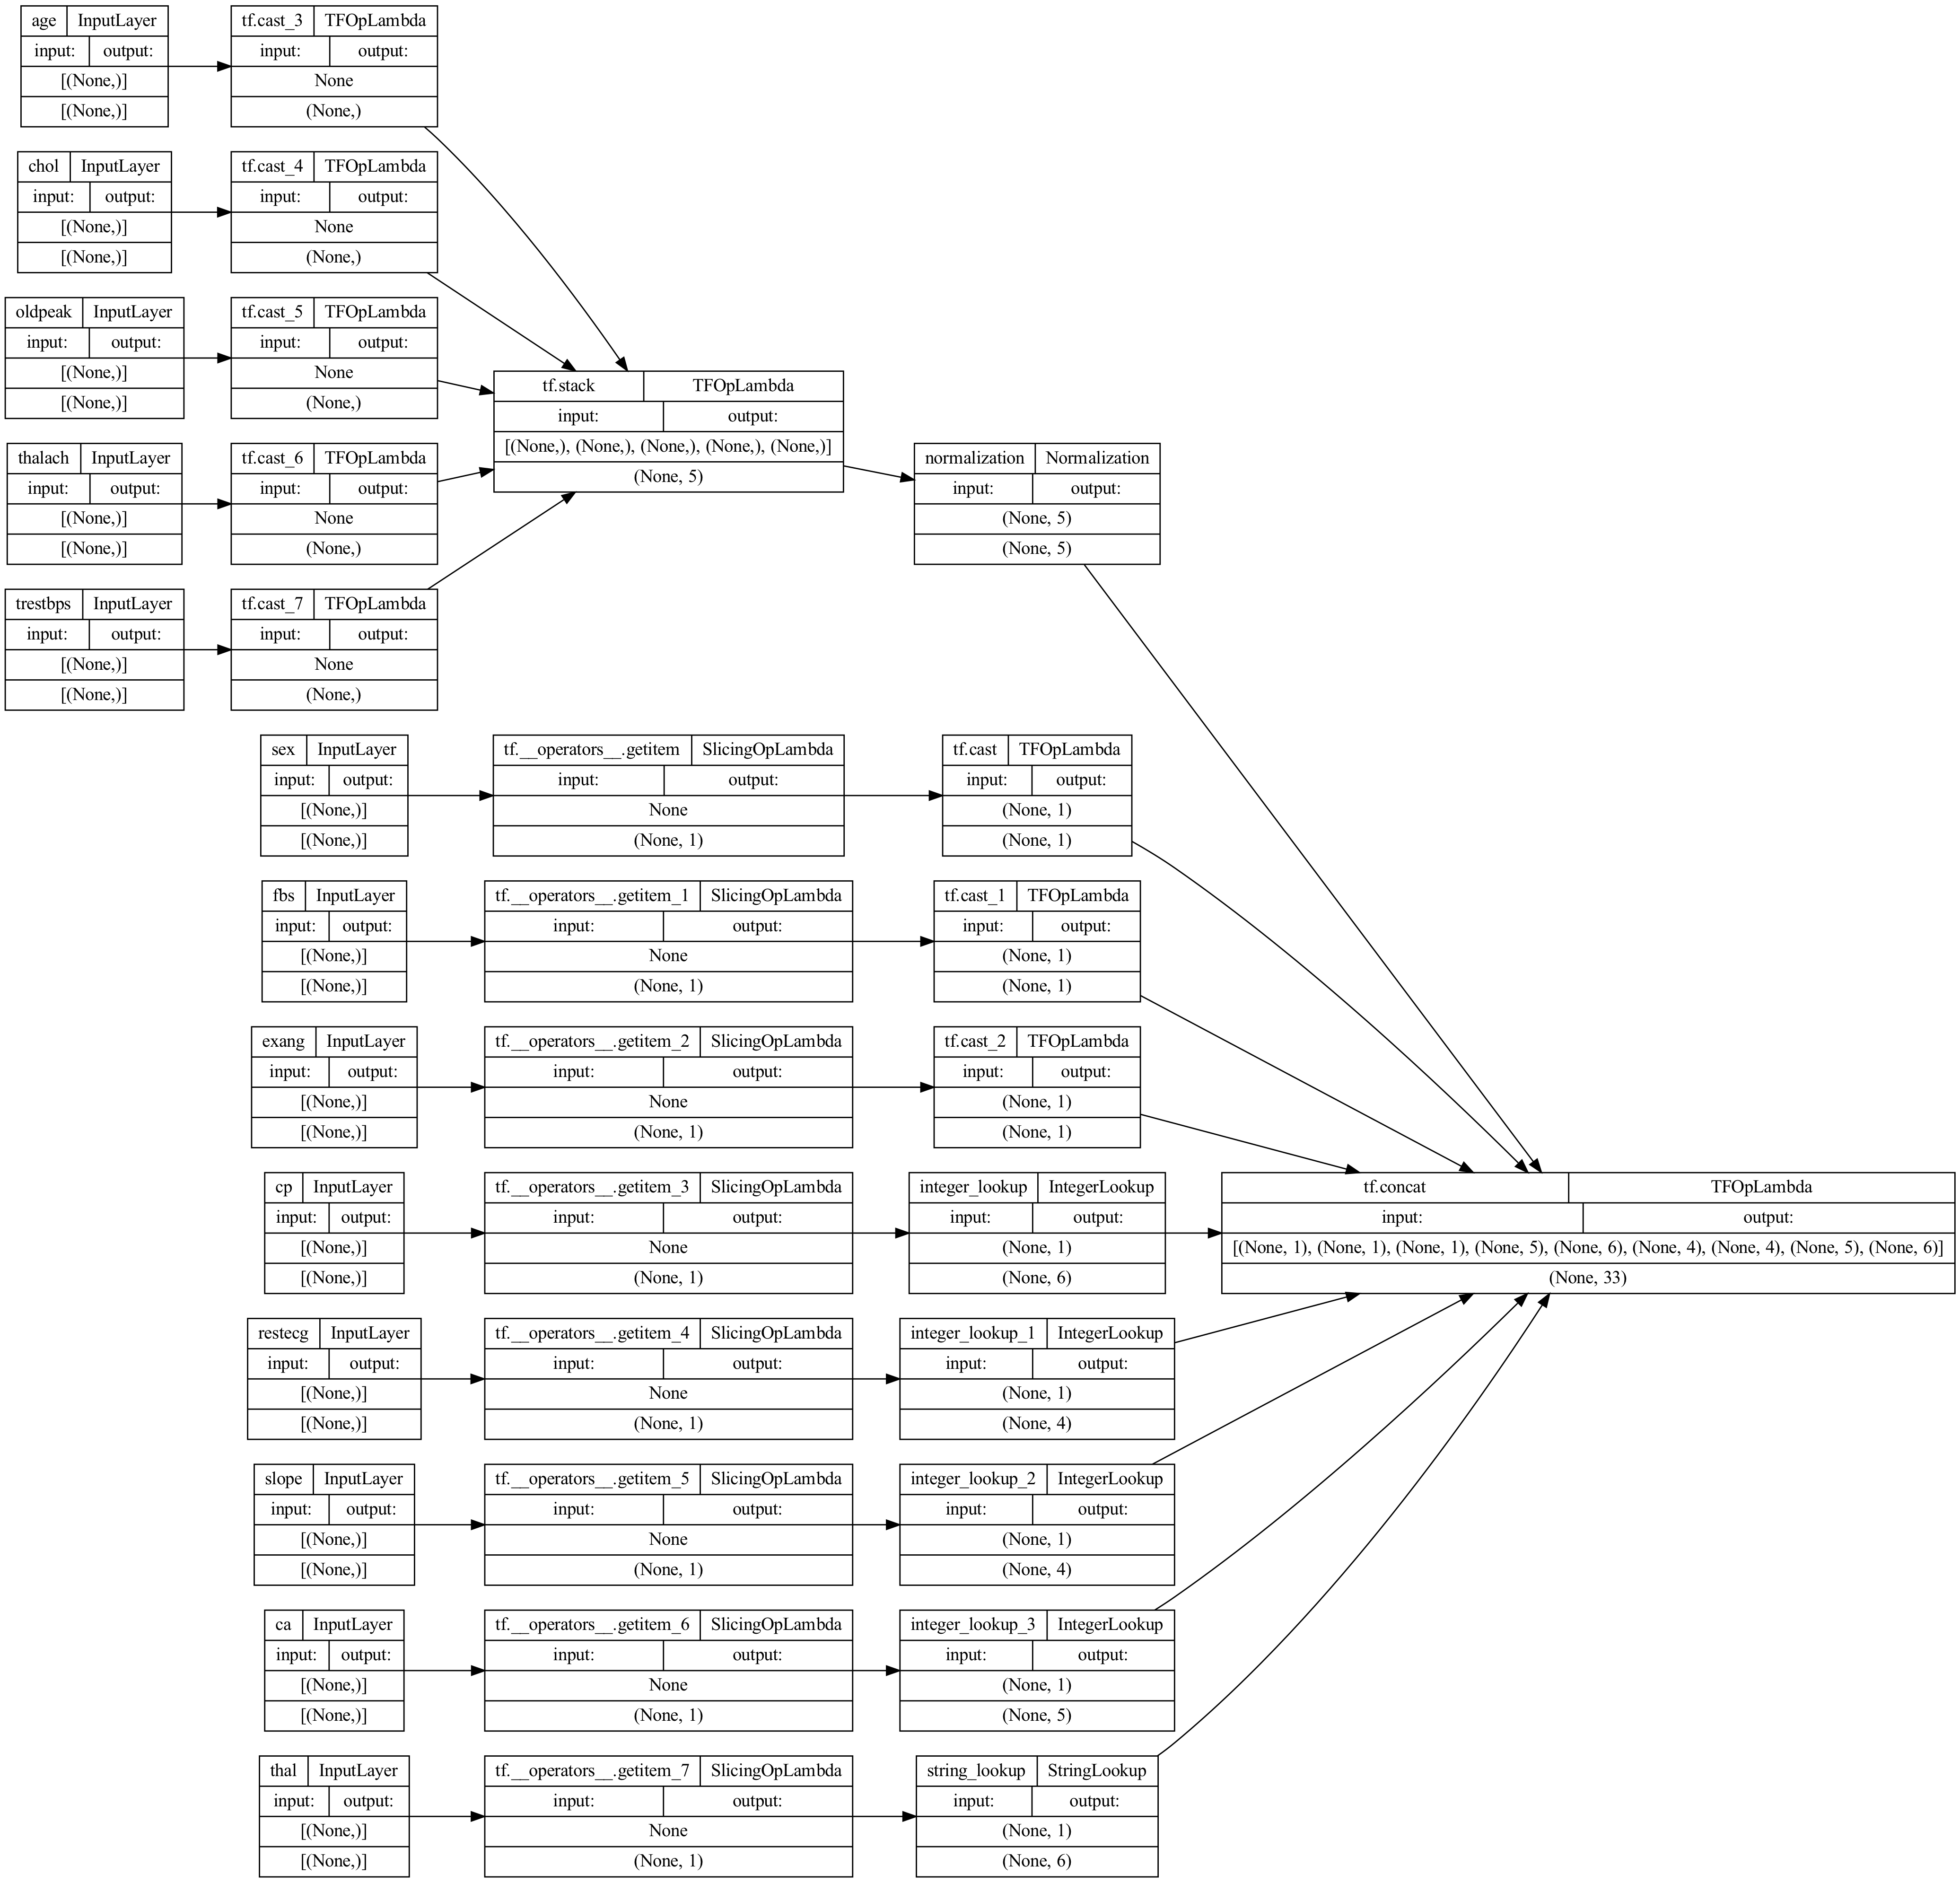

In [26]:
tf.keras.utils.plot_model(preprocessor, dpi=200, rankdir='LR', show_shapes=True)

In [27]:
preprocessor(dict(df.iloc[:1]))

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[ 1.        ,  1.        ,  0.        ,  0.933839  , -0.26008663,
         1.0680454 ,  0.03480718,  0.7457807 ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ]], dtype=float32)>

#### Create and train a model

In [28]:
body = Sequential([
    Dense(10, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

In [29]:
inputs

{'age': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'age')>,
 'sex': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'sex')>,
 'cp': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'cp')>,
 'trestbps': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'trestbps')>,
 'chol': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'chol')>,
 'fbs': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'fbs')>,
 'restecg': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'restecg')>,
 'thalach': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'thalach')>,
 'exang': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'exang')>,
 'oldpeak': <KerasTensor: shape=(None,) dtype=float32 (created by layer 'oldpeak')>,
 'slope': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'slope')>,
 'ca': <KerasTensor: shape=(None,) dtype=int64 (created by layer 'ca')>,
 'thal': <KerasTensor: shape=(None,) dtype=string 

In [30]:
x = preprocessor(inputs)
x

<KerasTensor: shape=(None, 33) dtype=float32 (created by layer 'model')>

In [31]:
result = body(x)
result

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'sequential')>

In [41]:
model = tf.keras.Model(inputs, result)

model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [42]:
history = model.fit(dict(df), target, epochs=5, batch_size=BATCH_SIZE)

Epoch 1/5
  6/152 [>.............................] - ETA: 1s - loss: 0.4554 - accuracy: 0.7500 

2022-08-06 22:16:15.508516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


152/152 [==============================] - 2s 9ms/step - loss: 0.3152 - accuracy: 0.8317
Epoch 2/5
152/152 [==============================] - 1s 9ms/step - loss: 0.3034 - accuracy: 0.8449
Epoch 3/5
152/152 [==============================] - 1s 9ms/step - loss: 0.2898 - accuracy: 0.8482
Epoch 4/5
152/152 [==============================] - 1s 9ms/step - loss: 0.2785 - accuracy: 0.8713
Epoch 5/5
152/152 [==============================] - 1s 9ms/step - loss: 0.2737 - accuracy: 0.8713


In [43]:
ds = tf.data.Dataset.from_tensor_slices((dict(df), target))

In [44]:
ds = ds.batch(BATCH_SIZE)

In [45]:
import pprint

for x, y in ds.take(1):
    pprint.pprint(x)
    print()
    print(y)

{'age': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([63, 67])>,
 'ca': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 3])>,
 'chol': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([233, 286])>,
 'cp': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 4])>,
 'exang': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>,
 'fbs': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>,
 'oldpeak': <tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.3, 1.5])>,
 'restecg': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 2])>,
 'sex': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1])>,
 'slope': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 2])>,
 'thal': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'fixed', b'normal'], dtype=object)>,
 'thalach': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([150, 108])>,
 'trestbps': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([145, 160])>}

tf.Tensor([0 1], shape=(2,), dtype=int64)


In [47]:
history = model.fit(ds, epochs=5)

Epoch 1/5
  6/152 [>.............................] - ETA: 1s - loss: 0.3710 - accuracy: 0.7500 

2022-08-06 22:16:40.879769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


152/152 [==============================] - 2s 9ms/step - loss: 0.2647 - accuracy: 0.8581
Epoch 2/5
152/152 [==============================] - 1s 9ms/step - loss: 0.2594 - accuracy: 0.8779
Epoch 3/5
152/152 [==============================] - 1s 9ms/step - loss: 0.2547 - accuracy: 0.8779
Epoch 4/5
152/152 [==============================] - 1s 9ms/step - loss: 0.2504 - accuracy: 0.8779
Epoch 5/5
152/152 [==============================] - 1s 8ms/step - loss: 0.2463 - accuracy: 0.8812
